In [9]:
#knn
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns

In [10]:
print(os.listdir("C:/Users/saumy/Downloads/dataset/BananaLSD/"))

SIZE = 64

['test', 'train']


In [11]:
train_images = []
train_labels = [] 
for directory_path in glob.glob("C:/Users/saumy/Downloads/dataset/BananaLSD/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
train_images = np.array(train_images)
train_labels = np.array(train_labels)

healthy
infected


In [12]:
#train_images = np.array(train_images)
#train_labels = np.array(train_labels)

In [13]:
test_images = []
test_labels = [] 
for directory_path in glob.glob("C:/Users/saumy/Downloads/dataset/BananaLSD/test/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [14]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded
###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0
#One hot encode y values for neural network. 
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
activation = 'sigmoid'
feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(MaxPooling2D(pool_size=(2, 2) ,strides=2))
feature_extractor.add(Conv2D(32, 3, activation = activation, input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(MaxPooling2D(pool_size=(2, 2) ,strides=2))

feature_extractor.add(Flatten())
#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(128, activation = activation)(x)
prediction_layer = Dense(2, activation = 'softmax')(x)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 
##########################################
#Train the CNN model
history = cnn_model.fit(x_train, y_train_one_hot, epochs=10, validation_data = (x_test, y_test_one_hot))




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272)              0  

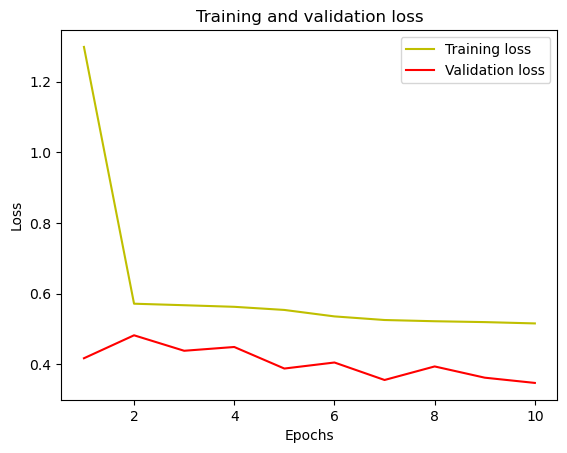

In [15]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

KeyError: 'acc'

In [17]:
prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

30/30 [==============================] - 1s 14ms/step


[[  1 128]
 [  7 801]]


<Axes: >

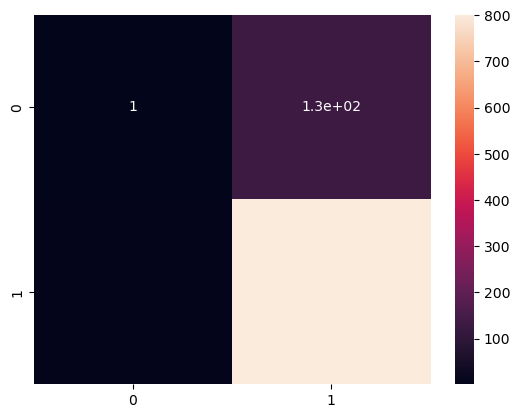

In [18]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction_NN)
print(cm)
sns.heatmap(cm, annot=True)

1/1 [==============================] - 0s 62ms/step
The prediction for this image is:  ['infected']
The actual label for this image is:  healthy


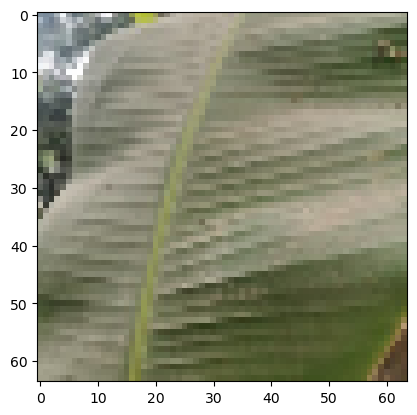

In [19]:
#n=5 dog park. NN not as good as RF.
n=9  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
prediction = np.argmax(cnn_model.predict(input_img))  #argmax to convert categorical back to original
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

In [20]:
################################
#Now, let us use features from convolutional network for RF
X_for_RF = feature_extractor.predict(x_train) #This is out X input to RF

50/50 [==============================] - 1s 13ms/step


In [21]:
#RANDOM FOREST
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_for_RF, y_train)


KNeighborsClassifier()

In [22]:
#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
prediction_RF = classifier.predict(X_test_feature)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

30/30 [==============================] - 1s 13ms/step


In [23]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.8228388473852721


<Axes: >

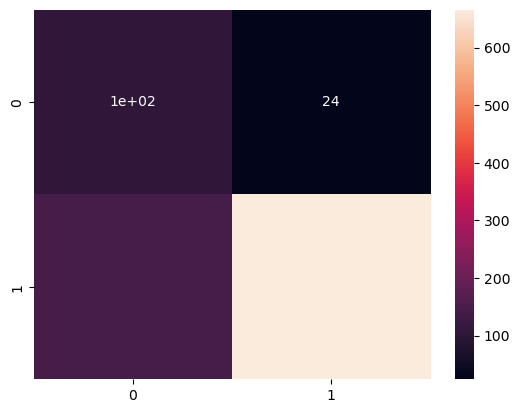

In [24]:
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

1/1 [==============================] - 0s 64ms/step
The prediction for this image is:  ['healthy']
The actual label for this image is:  healthy


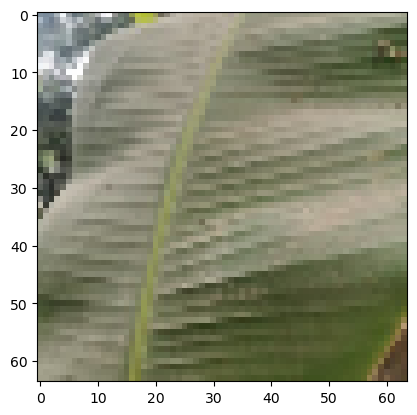

In [25]:
#Check results on a few select images
#n=5 #dog park. RF works better than CNN
n=9 #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor.predict(input_img)
prediction_RF = classifier.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])